# Boost and Rotate Stack Plot

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [3]:
print("filtering from", len(s_table), "total events")

# filter so we get events with 3 or 4 b-jets, and 3 tags
nb34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nj4 = s_table.njets >= 4 # at least 4 jets
nt3 = s_table.nbtags==3  # 3 b-tags
events = s_table[nb34 & nt3 & nj4]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]

n_events = len(events)
print(n_events)

filtering from 777150 total events
302694


In [4]:
cutoff = np.max(events.njets)
padding_val = 0

# pad events out to 'cutoff' events
events = tools.pad(events, cutoff)
# boost/rotate
events = tools.boost_and_rotate(events)

/home/callum/anaconda3/envs/437env/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


Don't worry if you see a warning about dividing by zero, fixing that!


In [5]:
# separate the 3 first jets from the rest since they're already tagged correctly
# (given our filtering procedure above)
px_3, px_rest = events.resolved_lv.p3.x[:, :3], events.resolved_lv.p3.x[:, 3:]
py_3, py_rest = events.resolved_lv.p3.y[:, :3], events.resolved_lv.p3.y[:, 3:]

  0%|          | 0/302694 [00:00<?, ?it/s]

237283


100%|██████████| 302694/302694 [00:01<00:00, 177060.74it/s]

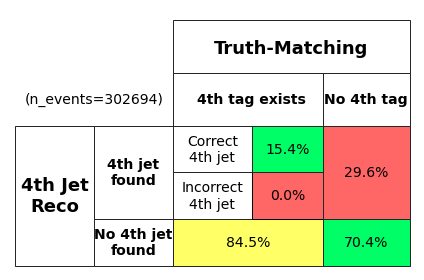

(15.44033750138968,
 0.009947163010596656,
 84.54971533559973,
 29.596861697688006,
 70.403138302312)

In [9]:
# find the best jet from _rest that fits with _3, in terms of pt sum = 0
px_3_sums = np.repeat(np.sum(px_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)
py_3_sums = np.repeat(np.sum(py_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)

px_sums = np.abs(px_rest + px_3_sums)
py_sums = np.abs(py_rest + py_3_sums)

magnitudes = np.sqrt(px_sums**2 + py_sums**2)
lowest_vals = np.min(magnitudes, axis=1)
lowest_indices = np.argmin(magnitudes, axis=1)

# lower values = more certainty
# let's set an arbitrary threshold,
# and say if lowest_val > thresh, pick no jet
thresh = 1
lowest_indices[lowest_vals>thresh] = cutoff-3

# also if the event was fine before adding a 4th jet, pick no jet
# this ends up having a small effect
px_sums_no_4th = np.abs(px_3_sums[:,0])
py_sums_no_4th = np.abs(py_3_sums[:,0])
magnitudes_no_4th = np.sqrt(px_sums_no_4th**2 + py_sums_no_4th**2)
lowest_indices[magnitudes_no_4th<thresh] = cutoff-3
print(np.count_nonzero(lowest_indices == cutoff-3))

# put this in a better format
selection_index = lowest_indices + 3
selections = np.zeros((len(events.truth), cutoff+1), dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1
# chop off last index so selection = [0,...,0] for no selection
selections = selections[:, :-1]

# compare to tag_u, truth_u
tools.evaluate_model(events.truth, events.tag, selections)


<Figure size 432x288 with 0 Axes>

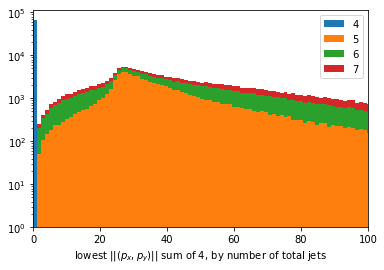

In [7]:
# stack plot
plt.cla();plt.clf()
fig, ax = plt.subplots()
n_list = list(range(4,8))
labels = [str(n) for n in n_list]
all_data_for_hist = np.array([lowest_vals[events.njets == n] for n in n_list])
ax.hist(all_data_for_hist, bins=1000, histtype='bar', stacked=True, label=labels)
plt.yscale('log')
plt.xlabel(f"lowest $||(p_x, p_y)||$ sum of 4, by number of total jets")
plt.legend(loc='upper right')
plt.xlim(0,100)
plt.show()